#### In this example we highlight one propoerty of DPDTree: trees from DPDTree do in average less tests on data, i.e. their deicison path is shorter. 

#### First, we get real data. The Avila bible dataset has 20000 samples, 10 features, and 12 classes.

In [1]:
import numpy as np
import urllib.request
import json

def get_avila_data(test=False):

    # Opening JSON file
    with open("avila.json") as json_file:
        data = json.load(json_file)
    if test:
        return np.array(data["Xtest"]), np.array(data["Ytest"])
    else:
        return np.array(data["Xtrain"]), np.array(data["Ytrain"])

print("downloading avila data ...")
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/KohlerHECTOR/dpdt-py/main/classification_datasets/avila.json",
    "avila.json",
)

downloading avila data ...


('avila.json', <http.client.HTTPMessage at 0x7a933651f8e0>)

#### Then we fit the default CART classifier from scikit-learn and DPDTree. We want trees with depth at most 4. 

In [2]:
from dpdt import DPDTree
from sklearn.tree import DecisionTreeClassifier

X, y = get_avila_data()
# DPDT
dpdt = DPDTree(max_depth=4, max_nb_trees=1000, random_state=42)
dpdt.fit(X, y)
print("Train accuracy DPDT: {}%".format(dpdt.score(X, y) * 100))
# CART
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)
print("Train accuracy sklearn default: {}%".format(clf.score(X, y) * 100))

Train accuracy DPDT: 59.20421860019175%
Train accuracy sklearn default: 57.11409395973155%


#### Then we use the model selections algorithms from DPDTree and CART and compare the test accuracy and average decision path lengths.

DPDTree.

In [3]:
from time import time
# Test
X_test, y_test = get_avila_data(test=True)

t = time()
scores_dpdt, avg_nb_tests_dpdt, _ = dpdt.get_pareto_front(X_test, y_test)
time_pareto_front_dpdt = time() - t

#### For cart, we need to define a function that counts the average decision path length.

In [4]:
def count_avg_test_cart(clf: DecisionTreeClassifier, X):
    node_indicator = clf.decision_path(X)
    return node_indicator.sum(axis=1).mean() - 1

CART.

In [5]:
t = time()
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
scores_clf, avg_nb_tests_clf = np.zeros_like(ccp_alphas), np.zeros_like(ccp_alphas)
for c, ccp_alpha in enumerate(ccp_alphas):
    clf = DecisionTreeClassifier(
        ccp_alpha=ccp_alpha,
        max_depth=4,
        random_state=42
    )
    clf.fit(X, y)
    scores_clf[c], avg_nb_tests_clf[c] = clf.score(X_test, y_test), count_avg_test_cart(
        clf, X_test
    )
time_pareto_front_clf = time() - t

#### Finally, we can plot the results. The point on the scatter plot represent performances of trees: x-axis is the test accuracy, and y-axis is the average decision path length 

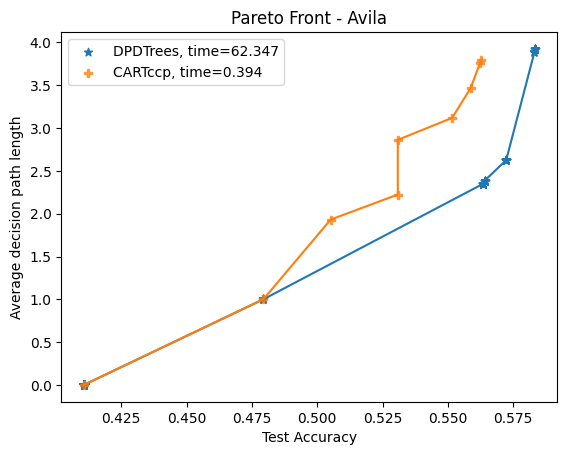

In [6]:
import matplotlib.pyplot as plt

plt.scatter(
    scores_dpdt,
    avg_nb_tests_dpdt,
    label="DPDTrees, time={}".format(round(time_pareto_front_dpdt, 3)),
    marker="*",
)
plt.plot(scores_dpdt, avg_nb_tests_dpdt)
plt.scatter(
    scores_clf,
    avg_nb_tests_clf,
    label="CARTccp, time={}".format(round(time_pareto_front_clf, 3)),
    marker="P",
    alpha=0.7,
)
plt.plot(scores_clf, avg_nb_tests_clf)
plt.xlabel("Test Accuracy")
plt.ylabel("Average decision path length")
plt.title("Pareto Front - Avila")
plt.legend()
plt.show()